In [1]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from model import MultimodalRegressor
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tools import plot_loss_function, model_comparison
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import os
import json
%pip install optuna -q
import optuna
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Note: you may need to restart the kernel to use updated packages.


### tab data

In [2]:
def cast_to_tensor(train, val, test=None):
    if isinstance(train, pd.DataFrame):
        train = train.values
    if isinstance(val, pd.DataFrame):
        val = val.values
    train_tensor = torch.tensor(train, dtype=torch.float32)
    val_tensor = torch.tensor(val, dtype=torch.float32)

    test_tensor = None
    if test is not None:
        if isinstance(test, pd.DataFrame):
            test = test.values
        test_tensor = torch.tensor(test, dtype=torch.float32)

    return train_tensor, val_tensor, test_tensor

In [3]:
test_ids = pd.read_csv("data/Test_rev1.csv")
test_ids = test_ids['Id']

In [4]:
train = pd.read_csv("data/train_preprocessed.csv")
val = pd.read_csv("data/val_preprocessed.csv")
test = pd.read_csv("data/test_preprocessed.csv", index_col='Id')

In [5]:
numeric_cols = ['CompanyEncoded', 'LocationPopulation']

scaler = MinMaxScaler(feature_range=(0, 1))
train[numeric_cols] = scaler.fit_transform(train[numeric_cols])
val[numeric_cols] = scaler.transform(val[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

# y
numeric_cols_y = ['SalaryNormalized']

scaler_y = MinMaxScaler(feature_range=(0, 1))
train[numeric_cols_y] = scaler_y.fit_transform(train[numeric_cols_y])
val[numeric_cols_y] = scaler_y.transform(val[numeric_cols_y])

In [6]:
y_train = train['SalaryNormalized']
y_val = val['SalaryNormalized']
X_train_tab = train.drop(columns=['SalaryNormalized'])
X_val_tab = val.drop(columns=['SalaryNormalized'])
X_test_tab = test

In [7]:
X_train_tab, X_val_tab, X_test_tab = cast_to_tensor(X_train_tab, X_val_tab, X_test_tab)
y_train, y_val = [t.reshape(-1, 1) for t in cast_to_tensor(y_train, y_val, None) if t is not None]

### text data

In [8]:
def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

In [9]:
data = 'uni_roberta'
if data == 'uni':
    X_train_text = np.load("data/X_train_text_uni.npy", allow_pickle=True)
    X_val_text = np.load("data/X_val_text_uni.npy", allow_pickle=True)
    X_test_text = np.load("data/X_test_text_uni.npy", allow_pickle=True)
if data == 'bi':
    X_train_text = np.load("data/X_train_text_bi.npy", allow_pickle=True)
    X_val_text = np.load("data/X_val_text_bi.npy", allow_pickle=True)
    # X_test_text = np.load("data/X_test_text_bi.npy", allow_pickle=True)
if data == 'tri':
    X_train_text = np.load("data/X_train_text_tri.npy", allow_pickle=True)
    X_val_text = np.load("data/X_val_text_tri.npy", allow_pickle=True)
    # X_test_text = np.load("data/X_test_text_tri.npy", allow_pickle=True)
if data == 'w2c':
    X_train_text = load_pickle("data/texts_w2v_train.pkl")
    X_val_text   = load_pickle("data/texts_w2v_val.pkl")
    X_test_text  = load_pickle("data/texts_w2v_test.pkl")
if data == 'roberta':
    X_train_text = pd.read_parquet('data/texts_roberta_train.parquet')
    X_val_text = pd.read_parquet('data/texts_roberta_val.parquet')
    X_test_text = pd.read_parquet('data/texts_roberta_test.parquet')
if data == 'uni_roberta':
    X_train_text = pd.read_parquet('data/texts_uni_roberta_train.parquet')
    X_val_text = pd.read_parquet('data/texts_uni_roberta_val.parquet')
    X_test_text = pd.read_parquet('data/texts_uni_roberta_test.parquet')

X_train_text, X_val_text,  X_test_text = cast_to_tensor(X_train_text, X_val_text, X_test_text)

In [10]:
print(X_train_text.shape)
print(X_val_text.shape)
print(X_train_tab.shape)

torch.Size([171336, 818])
torch.Size([73431, 818])
torch.Size([171336, 43])


## Training LightGBM

Join train and val - dense

In [41]:
# making dense data
def combine_and_to_numpy(text_tensor, tab_tensor, y_tensor=None):
    combined = torch.cat([text_tensor.to_dense(), tab_tensor], dim=1)
    combined_np = combined.cpu().numpy()
    if y_tensor is not None:
        y_np = y_tensor.cpu().numpy() if isinstance(y_tensor, torch.Tensor) else y_tensor
        return combined_np, np.ravel(y_np)
    return combined_np

X_train_np, y_train_np = combine_and_to_numpy(X_train_text, X_train_tab, y_train)
X_val_np, y_val_np = combine_and_to_numpy(X_val_text, X_val_tab, y_val)
X_test_np = combine_and_to_numpy(X_test_text, X_test_tab)

In [55]:
import os
import json
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd

exp_name = 'random_forest'
exp_path = f'logs/{exp_name}/'
os.makedirs(exp_path, exist_ok=True)

def rf_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    rf.fit(X_train_np, y_train_np)
    y_pred = rf.predict(X_val_np)
    mae = mean_absolute_error(y_val_np, y_pred)
    
    trial.set_user_attr("model_state", rf)
    
    # log trial
    trial_info = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "mae": mae
    }
    with open(os.path.join(exp_path, f"trial_{trial.number}.json"), "w") as f:
        json.dump(trial_info, f, indent=4)
    
    return mae

# --- Run study ---
study = optuna.create_study(direction="minimize")
study.optimize(rf_objective, n_trials=10, show_progress_bar=True)

# --- Best model and metrics ---
best_trial = study.best_trial
best_model = best_trial.user_attrs['model_state']
best_y_val_pred = best_model.predict(X_val_np)
best_r2 = r2_score(y_val_np, best_y_val_pred)

best_trial_info = {
    "trial_number": best_trial.number,
    "best_mae": study.best_value,
    "best_r2": best_r2,
    "best_params": best_trial.params
}

with open(os.path.join(exp_path, "best_trial.json"), "w") as f:
    json.dump(best_trial_info, f, indent=4)

# --- Predictions on test set ---
y_test_pred = best_model.predict(X_test_np)

submission_df = pd.DataFrame({
    "Id": test_ids,
    "Salary": y_test_pred.flatten()
})
submission_path = os.path.join(exp_path, "submission.csv")
submission_df.to_csv(submission_path, index=False)

print(f"Done! Logs and submission saved in {exp_path}")
print("Best MAE:", best_trial_info['best_mae'])
print("Best R2:", best_trial_info['best_r2'])

[I 2025-11-03 12:23:27,385] A new study created in memory with name: no-name-f2b283b4-ba55-4ac4-8bc9-4c812ea7a3c7


  0%|          | 0/10 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:  8.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    0.5s finished


[I 2025-11-03 12:31:58,571] Trial 0 finished with value: 0.03646848423794779 and parameters: {'n_estimators': 130, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.03646848423794779.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:  4.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  58 out of  58 | elapsed:    0.3s finished


[I 2025-11-03 12:36:15,623] Trial 1 finished with value: 0.03534921090100267 and parameters: {'n_estimators': 58, 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.03534921090100267.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 261 out of 261 | elapsed:  7.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 261 out of 261 | elapsed:    0.3s finished


[I 2025-11-03 12:43:19,654] Trial 2 finished with value: 0.04864758647542291 and parameters: {'n_estimators': 261, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 12}. Best is trial 1 with value: 0.03534921090100267.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 188 out of 188 | elapsed: 13.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 188 out of 188 | elapsed:    0.9s finished


[I 2025-11-03 12:56:20,565] Trial 3 finished with value: 0.035577061598246605 and parameters: {'n_estimators': 188, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.03534921090100267.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed: 10.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 183 out of 183 | elapsed:    0.5s finished


[I 2025-11-03 13:06:58,226] Trial 4 finished with value: 0.03820144415231802 and parameters: {'n_estimators': 183, 'max_depth': 13, 'min_samples_split': 18, 'min_samples_leaf': 16}. Best is trial 1 with value: 0.03534921090100267.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:  7.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 143 out of 143 | elapsed:    0.3s finished


[I 2025-11-03 13:13:58,516] Trial 5 finished with value: 0.04090865783057097 and parameters: {'n_estimators': 143, 'max_depth': 10, 'min_samples_split': 19, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.03534921090100267.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 293 out of 293 | elapsed: 14.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 293 out of 293 | elapsed:    0.6s finished


[I 2025-11-03 13:28:11,059] Trial 6 finished with value: 0.04082163333815622 and parameters: {'n_estimators': 293, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 16}. Best is trial 1 with value: 0.03534921090100267.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 282 out of 282 | elapsed: 18.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 282 out of 282 | elapsed:    1.1s finished


[I 2025-11-03 13:46:24,786] Trial 7 finished with value: 0.03648187978992286 and parameters: {'n_estimators': 282, 'max_depth': 17, 'min_samples_split': 16, 'min_samples_leaf': 16}. Best is trial 1 with value: 0.03534921090100267.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  6.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.4s finished


[I 2025-11-03 13:52:59,643] Trial 8 finished with value: 0.03607499940245334 and parameters: {'n_estimators': 96, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.03534921090100267.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.2s finished


[I 2025-11-03 13:58:28,462] Trial 9 finished with value: 0.04202027645792614 and parameters: {'n_estimators': 120, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 11}. Best is trial 1 with value: 0.03534921090100267.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  58 out of  58 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  58 out of  58 | elapsed:    0.4s finished


Done! Logs and submission saved in logs/random_forest/
Best MAE: 0.03534921090100267
Best R2: 0.6391584889704423


## Training networks

In [11]:
def create_loader(batch_size, X_text, X_tab, y=None, shuffle=True):
    if y is not None:
        dataset = TensorDataset(X_text, X_tab, y)
    else:
        dataset = TensorDataset(X_text, X_tab)
    
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [12]:
def prepare_dataloaders(batch_size, 
                        X_train_text, X_train_tab, y_train,
                        X_val_text, X_val_tab, y_val,
                        X_test_text=None, X_test_tab=None, y_test=None):
    
    train_loader = create_loader(batch_size, X_train_text, X_train_tab, y_train, shuffle=True)
    val_loader = create_loader(batch_size, X_val_text, X_val_tab, y_val, shuffle=False)
    
    test_loader = None
    if X_test_text is not None and X_test_tab is not None:
        test_loader = create_loader(batch_size, X_test_text, X_test_tab, y_test, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [13]:
def train_evaluate(model, optimizer, criterion, epochs, train_loader, test_loader, results_path='logs/',  patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    history = {"train_loss": [], "test_loss": [], 'r2': []}

    best_loss = float("inf")
    best_r2 = -float("inf")
    patience_counter = 0 
    
    for epoch in range(epochs):
        train_loss = 0.0
        # -----------TRAIN-------------
        model.train()
        for text_batch, tab_batch, y_batch in train_loader:
            text_batch = text_batch.to(device)
            tab_batch = tab_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            preds = model(text_batch, tab_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * text_batch.size(0)
    
        avg_train_loss = train_loss / len(train_loader.dataset)

        # -----------EVALUATE-------------
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for text_batch, tab_batch, y_batch in test_loader:
                text_batch = text_batch.to(device)
                tab_batch = tab_batch.to(device)
                y_batch = y_batch.to(device)
            
                preds_test = model(text_batch, tab_batch)
                loss = criterion(preds_test, y_batch)

                test_loss += loss.item() * text_batch.size(0) 
                
                all_preds.append(preds_test.detach().cpu())
                all_targets.append(y_batch.detach().cpu())

        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()

        avg_test_loss = test_loss / len(test_loader.dataset)
        r2 = r2_score(all_targets, all_preds)
        
        print(f"Epoch {epoch+1}/{epochs} - test_loss: {avg_test_loss:.4f}")
        
        history['train_loss'].append(avg_train_loss)
        history['test_loss'].append(avg_test_loss)
        history['r2'].append(r2)

        # early stopping
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if 'best_model_state' in locals():
        model.load_state_dict(best_model_state)
    
    # saving results
    os.makedirs(results_path, exist_ok=True)
    file_path = os.path.join(results_path, 'results.json')
    
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(history, f, ensure_ascii=False, indent=4)
        
    return history

In [14]:
model = MultimodalRegressor(text_dim=X_train_text.shape[1], tab_dim=X_train_tab.shape[1], dropout=0.3, hidden_dim=128)
loss_func = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
epochs = 10
train_loader, val_loader, _ = prepare_dataloaders(128, X_train_text, X_train_tab, y_train, X_val_text, X_val_tab, y_val)
history = train_evaluate(model, optimizer, loss_func, epochs, train_loader, val_loader)
plot_loss_function(history['train_loss'], history['test_loss'], 'baseline')
print(history['r2'][-1])

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ff975cad8a0>>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



# Feature Selection - Information Gain (IG)

In [257]:
X_test_combined = np.hstack([X_test_text, X_test_tab])

In [258]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [259]:
model.to(device)

MultimodalRegressor(
  (text_encoder): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (tab_encoder): Sequential(
    (0): Linear(in_features=43, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (fusion): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [260]:
X_val_text_tensor = X_val_text.clone().detach().requires_grad_(True)
X_val_tab_tensor  = X_val_tab.clone().detach().requires_grad_(True)
y_val_tensor      = y_val.clone().detach()
X_val_text_tensor = X_val_text_tensor.to(device)
X_val_tab_tensor  = X_val_tab_tensor.to(device)
y_val_tensor      = y_val_tensor.to(device)

In [261]:
ig = IntegratedGradients(model)

In [262]:
batch_size = 64
attr_text_list = []
attr_tab_list = []

for i in range(0, X_val_text_tensor.shape[0], batch_size):
    X_text_batch = X_val_text_tensor[i:i+batch_size].to(device)
    X_tab_batch = X_val_tab_tensor[i:i+batch_size].to(device)

    attr_text_batch, attr_tab_batch = ig.attribute(
        inputs=(X_text_batch, X_tab_batch),
        target=0,
        n_steps=20,
        return_convergence_delta=False
    )
    attr_text_list.append(attr_text_batch.detach().cpu())
    attr_tab_list.append(attr_tab_batch.detach().cpu())

attr_text = torch.cat(attr_text_list, dim=0)
attr_tab = torch.cat(attr_tab_list, dim=0)

In [263]:
text_feature_names = [f"text_{i}" for i in range(X_train_text.shape[1])]
tab_feature_names = list((train.drop(columns=['SalaryNormalized'])).columns)
all_feature_names = text_feature_names + tab_feature_names

In [264]:
attr_text_mean = attr_text.abs().mean(dim=0).detach().numpy()
attr_tab_mean = attr_tab.abs().mean(dim=0).detach().numpy()

feature_names = list(text_feature_names) + list(tab_feature_names)
importances = np.concatenate([attr_text_mean, attr_tab_mean])

In [265]:
print("all features: ", len(feature_names))

all features:  93


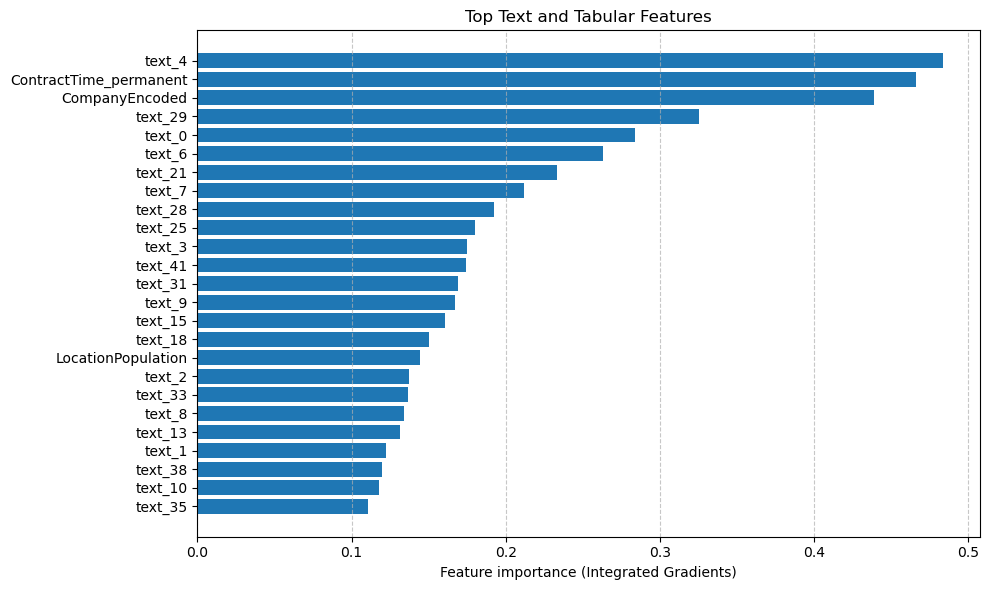

In [266]:
top_k = 25
sorted_idx = np.argsort(importances)[::-1][:top_k]

plt.figure(figsize=(10,6))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature importance (Integrated Gradients)")
plt.title("Top Text and Tabular Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.savefig(f'plots/{data}_TopTabularAndTextFeatures.png')
plt.show()
plt.close()

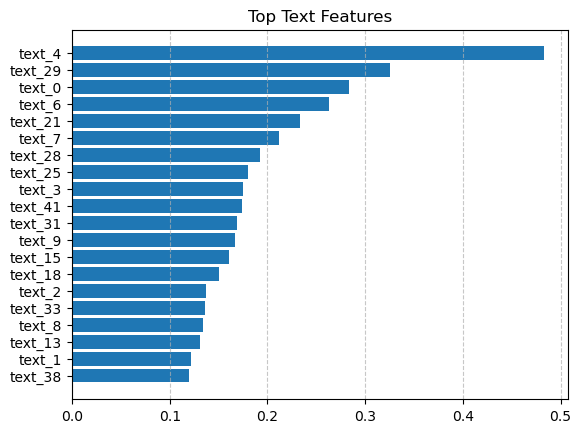

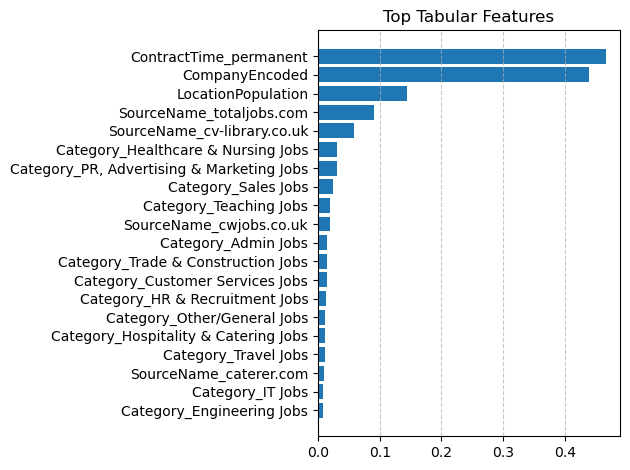

In [267]:
# text
sorted_idx_text = np.argsort(attr_text_mean)[::-1][:20]
plt.barh(np.array(text_feature_names)[sorted_idx_text], attr_text_mean[sorted_idx_text])
plt.title("Top Text Features")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.savefig(f'plots/{data}_TopTextFeatures.png')
plt.show()

# tab
sorted_idx_tab = np.argsort(attr_tab_mean)[::-1][:20]
plt.barh(np.array(tab_feature_names)[sorted_idx_tab], attr_tab_mean[sorted_idx_tab])
plt.title("Top Tabular Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.savefig(f'plots/{data}_TopTabularFeatures.png')
plt.show()
plt.close()

# Prepare top 25 selected features

In [ ]:
selected_cols = np.array(feature_names)[sorted_idx]
selected_idx = [all_feature_names.index(col) for col in selected_cols]

In [ ]:
text_idx = [i for i, name in enumerate(text_feature_names) if name in selected_cols]
tab_idx = [i for i, name in enumerate(tab_feature_names) if name in selected_cols]

X_train_text_selected = X_train_text[:, text_idx]
X_test_text_selected  = X_test_text[:, text_idx]

X_train_tab_selected = X_train_tab[:, tab_idx]
X_test_tab_selected  = X_test_tab[:, tab_idx]

print("Selected text features:", X_train_text_selected.shape)
print("Selected tab features:", X_train_tab_selected.shape)

In [ ]:
model = MultimodalRegressor(text_dim=X_train_text_selected.shape[1], tab_dim=X_train_tab_selected.shape[1], dropout=0.3)
loss_func = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

# Model comparison

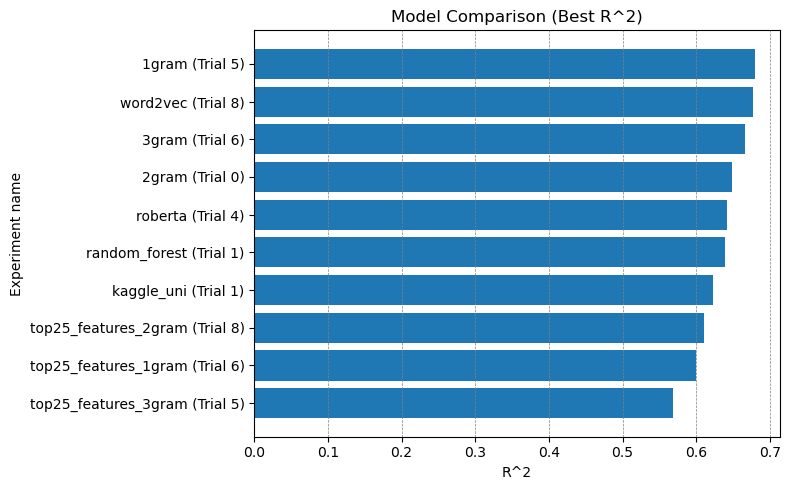

In [56]:
model_comparison()

# Optuna

In [14]:
def create_objective(X_train_text, X_train_tab, y_train, X_val_text, X_val_tab, y_val, exp_path, epochs):
    
    def objective(trial):
        
        lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
        dropout = trial.suggest_float("dropout", 0.3, 0.5)
        hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 128, 256, 512]) # 32, 64 (w2v, grams)
        batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
        weight_decay=trial.suggest_float("weight_decay", 0.0001, 0.001)
        
    
        text_dim = X_train_text.shape[1]
        tab_dim = X_train_tab.shape[1] 
        
        model = MultimodalRegressor(
            text_dim=text_dim, 
            tab_dim=tab_dim, 
            dropout=dropout, 
            hidden_dim=hidden_dim
        )
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        loss_func = nn.L1Loss()
        
        train_loader, test_loader, _ = prepare_dataloaders(
            batch_size, 
            X_train_text, X_train_tab, y_train, 
            X_val_text, X_val_tab, y_val
        )
    
        trial_name = f"trial_{trial.number}"
        results_path = os.path.join(exp_path, trial_name)
        
        history = train_evaluate(
            model, optimizer, loss_func, epochs=epochs,
            train_loader=train_loader, test_loader=test_loader, 
            results_path=results_path, patience=5
        )
    
        trial.set_user_attr('history', history)
        trial.set_user_attr('model_state', model.state_dict())
        best_test_r2 = max(history['r2'])
    
        return best_test_r2
    return objective

### selected features

In [269]:
# exp_name = 'top25_features'
# exp_path = f'logs/{exp_name}/'

# objective_fn = create_objective(
#     X_train_text = X_train_text_selected,
#     X_train_tab = X_train_tab_selected, 
#     y_train = y_train,
#     X_test_text = X_test_text_selected, 
#     X_test_tab = X_test_tab_selected, 
#     y_test = y_test,
#     exp_path = exp_path,
#     epochs = 30
# )

# study = optuna.create_study(direction="maximize") 
# study.optimize(objective_fn, n_trials=10, show_progress_bar=True) 

# print("Best R2:", study.best_value)
# print("Best params:", study.best_params)


# # save best results
# best_trial_info = {
#     "trial_number": study.best_trial.number,
#     "best_r2": study.best_value,
#     "best_params": study.best_params
# }

# os.makedirs(exp_path, exist_ok=True)
# with open(os.path.join(exp_path, 'best_trail.json'), "w", encoding="utf-8") as f:
#     json.dump(best_trial_info, f, indent=4)

### all features

In [15]:
exp_name = 'uni_roberta'
exp_path = f'logs/{exp_name}/'
os.makedirs(exp_path, exist_ok=True)

objective_fn = create_objective(
    X_train_text = X_train_text,
    X_train_tab = X_train_tab, 
    y_train = y_train,
    X_val_text = X_val_text, 
    X_val_tab = X_val_tab, 
    y_val = y_val,
    exp_path = exp_path,
    epochs = 30
)

study = optuna.create_study(direction="maximize")

study.optimize(objective_fn, n_trials=10, show_progress_bar=True) 

best_trial = study.best_trial
print(f"Best trial: ", {best_trial.number})
print("Best R2:", round(study.best_value, 3))
print("Best params:", study.best_params)


# save best results
best_trial_info = {
    "trial_number": study.best_trial.number,
    "best_r2": study.best_value,
    "best_params": study.best_params
}


with open(os.path.join(exp_path, "best_trial.json"), "w", encoding="utf-8") as f:
    json.dump({
        "trial_number": best_trial.number,
        "best_r2": study.best_value,
        "best_params": best_trial.params
    }, f, indent=4)


# Kaggle submission.csv - contest file
best_trial = study.best_trial
best_model_state = best_trial.user_attrs['model_state']

best_model = MultimodalRegressor(
    text_dim=X_test_text.shape[1], 
    tab_dim=X_test_tab.shape[1],
    dropout=best_trial.params['dropout'],
    hidden_dim=best_trial.params['hidden_dim']
)
best_model.load_state_dict(best_model_state)
best_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

all_preds = []
batch_size = best_trial.params['batch_size']
with torch.no_grad():
    for i in range(0, len(X_test_text), batch_size):
        text_batch = X_test_text[i:i+batch_size].detach().float().to(device)
        tab_batch = X_test_tab[i:i+batch_size].detach().float().to(device)
        preds = best_model(text_batch, tab_batch)
        all_preds.append(preds.cpu())

all_preds = torch.cat(all_preds).numpy()
y_pred_original = scaler_y.inverse_transform(all_preds)

submission_df = pd.DataFrame({
    "Id": test_ids,
    "Salary": y_pred_original.flatten()
})

submission_path = os.path.join(exp_path, "submission.csv")
submission_df.to_csv(submission_path, index=False)

[I 2025-11-04 08:55:20,571] A new study created in memory with name: no-name-e59a06ff-eac7-43ed-99ed-701f0b9eb768


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/30 - test_loss: 0.0400
Epoch 2/30 - test_loss: 0.0396
Epoch 3/30 - test_loss: 0.0383
Epoch 4/30 - test_loss: 0.0390
Epoch 5/30 - test_loss: 0.0380
Epoch 6/30 - test_loss: 0.0382
Epoch 7/30 - test_loss: 0.0387
Epoch 8/30 - test_loss: 0.0382
Epoch 9/30 - test_loss: 0.0380
Epoch 10/30 - test_loss: 0.0384
Epoch 11/30 - test_loss: 0.0384
Epoch 12/30 - test_loss: 0.0405
Epoch 13/30 - test_loss: 0.0385
Epoch 14/30 - test_loss: 0.0377
Epoch 15/30 - test_loss: 0.0380
Epoch 16/30 - test_loss: 0.0383
Epoch 17/30 - test_loss: 0.0379
Epoch 18/30 - test_loss: 0.0380
Epoch 19/30 - test_loss: 0.0385
Early stopping at epoch 19
[I 2025-11-04 09:00:47,513] Trial 0 finished with value: 0.5991746187210083 and parameters: {'lr': 0.00016382055316051868, 'dropout': 0.33136948318496245, 'hidden_dim': 128, 'batch_size': 32, 'weight_decay': 0.0006197247360765173}. Best is trial 0 with value: 0.5991746187210083.
Epoch 1/30 - test_loss: 0.0459
Epoch 2/30 - test_loss: 0.0430
Epoch 3/30 - test_loss: 0.0415
E

### Count metrics

In [68]:
results = pd.read_csv('data/results.csv', index_col='Id')
submission = pd.read_csv('logs/kaggle_uni/submission.csv', index_col='Id')
df_merged = pd.merge(results, submission, on="Id")
df_merged = df_merged.rename(columns={
    "SalaryNormalized": "True_Salary",
    "Salary": "Predicted_Salary"
})
mae = mean_absolute_error(df_merged["True_Salary"], df_merged["Predicted_Salary"])
print(f"MAE: {mae:.5f}")

MAE: 6014.59593


In [82]:
leaderboard = pd.read_csv('data/leaderboard.csv', index_col='Rank')
first_index = (leaderboard['Score'] > mae).idxmax()
print("Rank in leaderboard: ", first_index)

Rank in leaderboard:  39
